In [1]:
# import packages
import zipfile
import urllib.request

import pandas as pd
import numpy as np
import sklearn.metrics
import sklearn.ensemble
import sklearn.model_selection

from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.models import KeyedVectors

import seaborn as sns
sns.set_style('whitegrid')
sns.set_context('talk')

In [2]:
# download pre-trained GloVe vectors from the website
URL = 'https://nlp.stanford.edu/data/glove.6B.zip'
FILE_NAME = 'glove.6B.zip'
urllib.request.urlretrieve(URL, FILE_NAME)

with zipfile.ZipFile(FILE_NAME, 'r') as zip_ref:
    zip_ref.extractall()

# transfer pre-trained GloVe vectors into word2vec format
GLOVE_FILE = 'glove.6B.100d.txt'
WORD2VEC_FILE = GLOVE_FILE + '.word2vec'
glove2word2vec(GLOVE_FILE, WORD2VEC_FILE)

# load pre-trained GloVe vectors
glove_model = KeyedVectors.load_word2vec_format(WORD2VEC_FILE, binary=False)

/var/folders/gy/5v8v142s4fz6nz5xwllrz4b40000gn/T/ipykernel_89290/779987310.py:12: DeprecationWarning: Call to deprecated `glove2word2vec` (KeyedVectors.load_word2vec_format(.., binary=False, no_header=True) loads GLoVE text vectors.).
  glove2word2vec(GLOVE_FILE, WORD2VEC_FILE)


In [3]:
# load dataset
df1 = pd.read_excel('../../Downloads/CHEME DIRECT/NLP Project/PSE Dataset.xlsx', sheet_name='SamePerson Report')
df2 = pd.read_excel('../../Downloads/CHEME DIRECT/NLP Project/PSE Dataset.xlsx', sheet_name='Multiple People Report')
df3 = pd.read_excel('../../Downloads/CHEME DIRECT/NLP Project/PSE Dataset.xlsx', sheet_name='Multiple People Less Details')

In [4]:
train_1, test_1 = sklearn.model_selection.train_test_split(df1, test_size=0.2, random_state=206)
train_2, test_2 = sklearn.model_selection.train_test_split(df2, test_size=0.2, random_state=206)
train_3, test_3 = sklearn.model_selection.train_test_split(df3, test_size=0.2, random_state=206)

In [5]:
train_1_text = train_1['Report'].values.reshape(-1,1)
test_1_text = test_1['Report'].values.reshape(-1,1)

train_1_label = train_1['Level'].values.reshape(-1,1)
test_1_label = test_1['Level'].values.reshape(-1,1)

train_2_text = train_2['Report'].values.reshape(-1,1)
test_2_text = test_2['Report'].values.reshape(-1,1)

train_2_label = train_2['Level'].values.reshape(-1,1)
test_2_label = test_2['Level'].values.reshape(-1,1)

train_3_text = train_3['Report'].values.reshape(-1,1)
test_3_text = test_3['Report'].values.reshape(-1,1)

train_3_label = train_3['Level'].values.reshape(-1,1)
test_3_label = test_3['Level'].values.reshape(-1,1)

In [6]:
# define functions for tokenizing the text data
class Word2VecVectorizer:
    def __init__(self, model_vec):
        print("Loading in word vectors...")
        self.word_vectors = model_vec
        print("Finished loading in word vectors")

    def fit(self, data):
        """fit data"""

    def transform(self, data):
        """determine the dimensionality of vectors"""
        v_get = self.word_vectors.get_vector('king')
        self.D = v_get.shape[0]

        x_vec = np.zeros((len(data), self.D))
        n_count = 0
        emptycount = 0

        for sentence in data:
            tokens = sentence.split()
            vecs = []
            m_count = 0
            for word in tokens:
                try:
                    # throws KeyError if word not found
                    vec = self.word_vectors.get_vector(word)
                    vecs.append(vec)
                    m_count += 1
                except KeyError:
                    pass

            if len(vecs) > 0:
                vecs = np.array(vecs)
                x_vec[n_count] = vecs.mean(axis=0)
            else:
                emptycount += 1
            n_count += 1

        print("Numer of samples with no words found: %s / %s" % (emptycount,
        	len(data)))
        return x_vec

    def fit_transform(self, data):
        """transform the strings to vectors"""
        self.fit(data)

        return self.transform(data)

In [40]:
train_1_text_list = train_1_text.tolist()
train_1_text_str = [item for sublist in train_1_text_list for item in sublist]

test_1_text_list = test_1_text.tolist()
test_1_text_str = [item for sublist in test_1_text_list for item in sublist]

train_1_label_list = train_1_label.tolist()
train_1_label_str = [item for sublist in train_1_label_list for item in sublist]

test_1_label_list = test_1_label.tolist()
test_1_label_str = [item for sublist in test_1_label_list for item in sublist]

In [46]:
# set a word vectorizer
vectorizer = Word2VecVectorizer(glove_model)

# get the sentence embeddings for the train dataset
train_x = vectorizer.fit_transform(train_1_text_str)
train_y = train_1_label_str

# get the sentence embeddings for the test dataset
test_x = vectorizer.transform(test_1_text_str)
test_y = test_1_label_str

Loading in word vectors...
Finished loading in word vectors
Numer of samples with no words found: 0 / 80
Numer of samples with no words found: 0 / 20


In [47]:
# train a Random Forest model
model = sklearn.ensemble.RandomForestClassifier(n_estimators=200)

model.fit(train_x, train_y)

RandomForestClassifier(n_estimators=200)

In [48]:
# accuracy report
print("model accuracy:", model.score(test_x, test_y))

predict_y = model.predict(test_x)

print(sklearn.metrics.classification_report(test_y, predict_y, digits=4))

model accuracy: 0.75
              precision    recall  f1-score   support

           1     1.0000    1.0000    1.0000         2
           2     0.0000    0.0000    0.0000         0
           3     1.0000    0.3333    0.5000         6
           4     0.8333    0.8333    0.8333         6
           5     0.8571    1.0000    0.9231         6

    accuracy                         0.7500        20
   macro avg     0.7381    0.6333    0.6513        20
weighted avg     0.9071    0.7500    0.7769        20



/Users/Jlonging/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/Jlonging/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/Jlonging/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


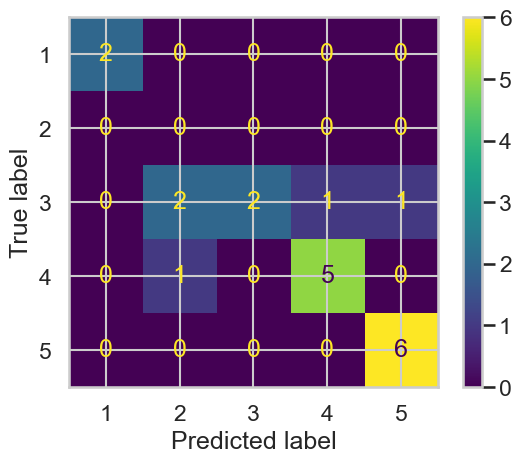

In [49]:
# plot a confusion matrix
sklearn.metrics.ConfusionMatrixDisplay.from_estimator(model, test_x, test_y)